# Purpose
Generate a visual of the counties that have been visited.

# Setup
## Import - Packages

In [1]:
# ---------------------------------------------------------------------------- #
# GENERAL #
import pathlib as pl

# ---------------------------------------------------------------------------- #
# ANALYSIS #
import numpy as np
import pandas as pd
import siuba as s

# ---------------------------------------------------------------------------- #
# SPATIAL #
import geopandas as gpd

from shapely.geometry import LineString
from shapely.ops import split
from shapely.affinity import translate
from shapely.ops import unary_union

# ---------------------------------------------------------------------------- #
# VISUALIZATION
import plotnine as p9

# ---------------------------------------------------------------------------- #
# LOCAL #
from tracking_counties.config import ROOT_DIR, EPSG_CODE, NON_CONTIGUOUS_CODES
from tracking_counties.scripts.data import import_data 
from tracking_counties.scripts.processing import process_data

# Process

In [2]:
# Import datasets
df_visit_county, gdf_county, gdf_state = import_data()

# Process Datasets
gdf_county, gdf_state = process_data(
        df_visited = df_visit_county,
        gdf_county = gdf_county,
        gdf_state  = gdf_state
    )

In [3]:
def shift_meridian(geo_df, new_centerline): 
    """
    Shift geometries in a GeoDataFrame to be centered around a new central meridian.

    Parameters
    ----------
    geo_df : geopandas.GeoDataFrame
        A GeoDataFrame containing the geometries to be shifted.
    new_centerline : float
        The longitude of the new central meridian (in degrees).

    Returns
    -------
    geopandas.GeoDataFrame
        A new GeoDataFrame with geometries shifted to the new central meridian.
    
    Reference
    -------
    https://stackoverflow.com/questions/58750837/set-centre-of-geopandas-map        
    https://stackoverflow.com/questions/40385782/make-a-union-of-polygons-in-geopandas-or-shapely-into-a-single-geometry
    """

    # Define new central meridian
    central_meridian = LineString([
        (new_centerline, 90),
        (new_centerline, -90)
        ])

    # Init
    gframes  = []

    for _, row in geo_df.iterrows():

        # Extract values
        element = row['geometry']

        # Split current geometry by new central meridian.
        split_geoms = split(element, central_meridian)

        # Init
        shifted_parts = []
        for part in split_geoms.geoms:
            
            min_x = part.bounds[0]  # Extract minimum x (longitude)

            # Determine the translation direction
            if min_x >= new_centerline:
                adjust_factor = -1
            else:
                adjust_factor = 1
            
            # Calculate the translation offset
            x_off = (180 * adjust_factor) - new_centerline

            # Translate geometry
            shifted_part = translate(
                part, 
                xoff = x_off
                )

            shifted_parts.append(shifted_part)
        
        # Combine the shifted parts into a single geometry
        unified_geom = gpd.GeoSeries(unary_union(shifted_parts))

        # Converty unified geometries into geo dataframe
        gdf_geom_shift = gpd.GeoDataFrame(
            {
                "geometry": unified_geom
                }
            )
        gframes.append(gdf_geom_shift)

    # Concatenate all geo dataframes togeter
    gdf_unify = pd.concat(gframes)

    # Assign original index to new geometry dataframe
    gdf_unify.index = geo_df.index

    # Concatenate new transposed geo dataframe back to initial 
    geo_df = pd.concat(
        [
            geo_df.drop(columns= ['geometry']), 
            gdf_unify
            ],
        axis = 1
    )

    return geo_df

def adjust_crs(gdf, epsg):
    gdf = gdf.to_crs(epsg = EPSG_CODE)


In [4]:
def adjust_crs(gdf, epsg):
    gdf = gdf.to_crs(epsg = epsg)
    return gdf

# Generate Tables for Specific Plots

In [5]:
dct_plot = {
    'state': {},
    'county': {}
}

## Contiguous US

In [6]:
plot_type = 'contiguous'

dct_plot['state'][plot_type] = (
    gdf_state
    >> s.filter(~s._.geoid.isin(NON_CONTIGUOUS_CODES)
    )
)

dct_plot['county'][plot_type] = (
    gdf_county
    >> s.filter(~s._.statefp.isin(NON_CONTIGUOUS_CODES)
    )
)


### Adjust CRS
* Only adjust for Continuous US
* Based on preference, but Alaska and Hawaii look better in default projection.
* TO DO: Test other projections for Alaska / Hawaii?

In [7]:
dct_plot['state'][plot_type] = \
    adjust_crs(dct_plot['state'][plot_type], epsg = EPSG_CODE)

dct_plot['county'][plot_type] = \
    adjust_crs(dct_plot['county'][plot_type], epsg = EPSG_CODE)

### Alaska

In [8]:
plot_type = 'alaska'

dct_plot['state'][plot_type] = (
    gdf_state
    >> s.filter(s._.geoid == '02')
    )   

dct_plot['county'][plot_type] = (
    gdf_county
    >> s.filter(s._.statefp == '02')
    )


### Shift Meridian
* Shift center meridian to avoid splitting Alaska plot.

In [9]:
plot_type = 'alaska'

# Define new center meridian
cl = 90

# Shift projections
dct_plot['state'][plot_type] = shift_meridian(dct_plot['state'][plot_type], cl)
dct_plot['county'][plot_type] = shift_meridian(dct_plot['county'][plot_type], cl)

### Hawaii

In [10]:
plot_type = 'hawaii'

dct_plot['state'][plot_type] = (
    gdf_state
    >> s.filter(s._.geoid == '15')
    )   

dct_plot['county'][plot_type] = (
    gdf_county
    >> s.filter(s._.statefp == '15')
    )


# Visuals


In [16]:
def save_plot(plot, plot_path, width, height, units = 'in', dpi = 1000):
    plot.save(
        filename = plot_path,
        height   = height,
        width    = width,
        units    = units,
        dpi      = dpi
    )

## Settings

In [20]:
plot_dir = pl.PurePath(ROOT_DIR, 'data', 'plots')

plot_params = {
    'color': {
        0: "#F4F6F6", 
        1: "#1F618D",
    },
    'opacity': {
        0: 0, 
        1: 0.15
    },
    'entity_border': {
        'color': {
            'county': "#717d7e", # Gray80
            'state': "#000000"   # Black
        },
        'thickness': {
            'county': 0.2,
            'state': 0.5
        }
    },
    'dimensions': {
        'height': {
            'contiguous': 6,
            'alaska': 6,
            'hawaii': 6
        },
        'width': {
            'contiguous': 10,
            'alaska': 7,
            'hawaii': 6,
        }
    }
}


## Contiguous US

In [18]:
plot_label = 'contiguous'

p = (
    p9.ggplot() +
    p9.geom_map(
        data = dct_plot['county'][plot_label],
        mapping = p9.aes(
            fill = 'visited'
        ),
        color = plot_params['entity_border']['color']['county'],
        size = plot_params['entity_border']['thickness']['county'],
        ) +
    p9.geom_map(
        data = dct_plot['state'][plot_label],
        mapping = p9.aes(
            fill = 'visited',
            alpha = 'visited'
        ),
        color = plot_params['entity_border']['color']['state'],
        size = plot_params['entity_border']['thickness']['state']
        ) +
    p9.scale_fill_manual(
        values = plot_params['color'], 
        guide = False
        ) + 
    p9.scale_alpha_manual(
        values = plot_params['opacity'],
        guide  = False
        ) + 
    p9.theme_linedraw() + 
    p9.theme(
        figure_size=(
            plot_params['dimensions']['width'][plot_label],
            plot_params['dimensions']['height'][plot_label]
            )
    )
)

plot_name = f'{plot_label}.png'

save_plot(
    plot      = p, 
    plot_path = pl.PurePath(plot_dir, plot_name), 
    width     = plot_params['dimensions']['width'][plot_label], 
    height    = plot_params['dimensions']['height'][plot_label]
    )

/Users/evancanfield/.pyenv/versions/3.11.5/envs/.tracking_counties_3115/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
/Users/evancanfield/.pyenv/versions/3.11.5/envs/.tracking_counties_3115/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/evancanfield/Documents/Projects/trackingcounties/data/plots/contiguous.png


## Alaska


In [22]:
plot_params['dimensions']['width'][plot_label]

6

In [23]:
plot_params['dimensions']['height'][plot_label]

7

/Users/evancanfield/.pyenv/versions/3.11.5/envs/.tracking_counties_3115/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 7 in image.
/Users/evancanfield/.pyenv/versions/3.11.5/envs/.tracking_counties_3115/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/evancanfield/Documents/Projects/trackingcounties/data/plots/alaska.png


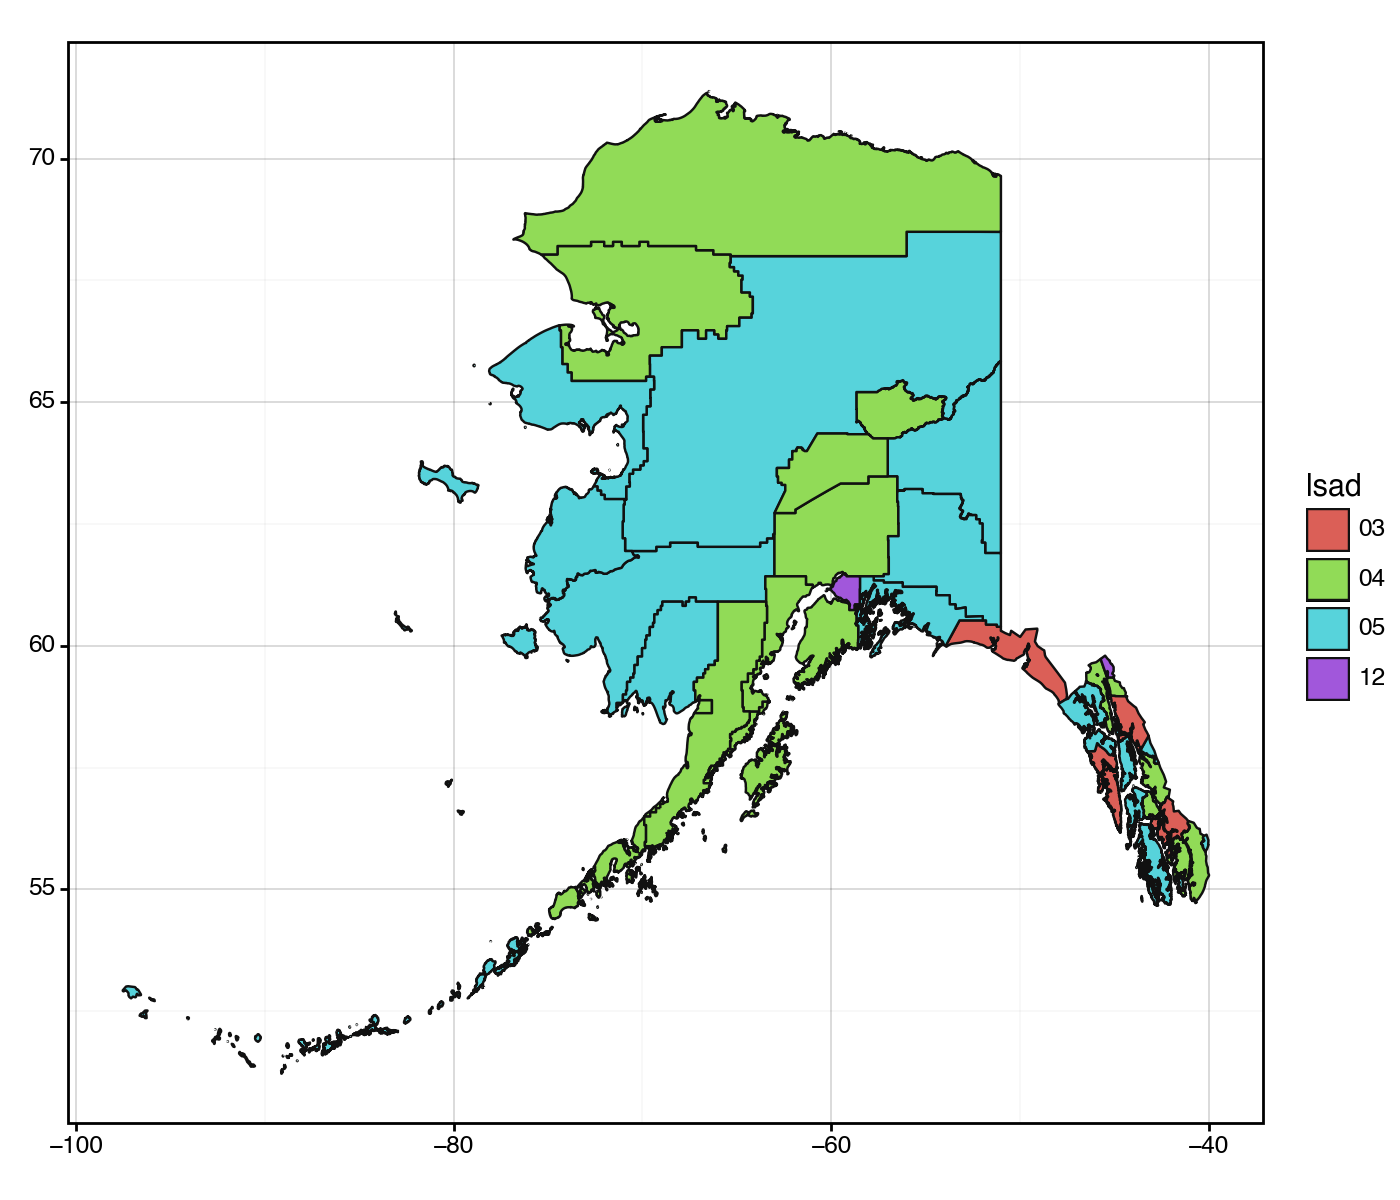

<Figure Size: (700 x 600)>

In [21]:
plot_label = 'alaska'

p = (
    p9.ggplot(
        data = dct_plot['county'][plot_label],
        mapping = p9.aes(
            fill = 'lsad',
        )
    ) +
    p9.geom_map() +
    p9.theme_linedraw() + 
    p9.theme(
        figure_size=(7,6)
    )
)

plot_name = f'{plot_label}.png'

save_plot(
    plot      = p, 
    plot_path = pl.PurePath(plot_dir, plot_name), 
    width     = plot_params['dimensions']['width'][plot_label], 
    height    = plot_params['dimensions']['height'][plot_label]
    )

p

## Hawaii

In [ ]:
plot_label = 'hawaii'

p = (
    p9.ggplot(
        data = dct_plot['county'][plot_label],
        mapping = p9.aes(
            fill = 'visited'
        )
    ) +
    p9.geom_map() +
    p9.coord_cartesian(
        xlim = (-162, -153),
        ylim = (16, 26)
    ) + 
    p9.theme_linedraw() +
    p9.theme(
        figure_size=(6, 6)
    )
)

plot_name = f'{plot_label}.png'

save_plot(
    plot      = p, 
    plot_path = pl.PurePath(plot_dir, plot_name), 
    width     = plot_params['dimensions']['width'][plot_label], 
    height    = plot_params['dimensions']['height'][plot_label]
    )

p